In [1]:
import sys
print(sys.executable)


C:\Users\ayush\AppData\Local\Programs\Python\Python313\python.exe


In [1]:
import sys
print(sys.executable)


C:\Users\ayush\AppData\Local\Programs\Python\Python313\python.exe


In [2]:
!{sys.executable} -m pip install earthengine-api


  Using cached earthengine_api-1.6.4-py3-none-any.whl.metadata (2.2 kB)
  Using cached google_auth-2.40.3-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached httplib2-0.30.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached google_api_core-2.25.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached uritemplate-4.2.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl.metadata (2.7 kB)
 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\ayush\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [1]:
import ee
ee.Authenticate()

True

In [2]:
ee.Initialize()


In [10]:
!pip install geemap


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
   ---------------------------------------- 0.0/631.5 kB ? eta -:--:--
   ---------------------------------------- 631.5/631.5 kB 8.0 MB/s  0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 13.6 MB/s  0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.6 MB/s  0:00:00
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 

In [27]:
import ee
import matplotlib.pyplot as plt


In [28]:
coords = [
    [13.010755379590536, 12.460041970862635],
    [15.367322762403036, 12.460041970862635],
    [15.367322762403036, 14.33557555267123],
    [13.010755379590536, 14.33557555267123],
    [13.010755379590536, 12.460041970862635]
]
region = ee.Geometry.Polygon([coords])

In [29]:
def addNDWI(image, green, nir):
    ndwi = image.normalizedDifference([green, nir]).rename('NDWI')
    return image.addBands(ndwi)

In [30]:
# Landsat collections
landsat5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
    .filterBounds(region).filterDate("1984-01-01", "2012-05-05") \
    .map(lambda img: addNDWI(img, 'SR_B2', 'SR_B4'))

In [31]:
landsat7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
    .filterBounds(region).filterDate("1999-01-01", "2022-12-31") \
    .map(lambda img: addNDWI(img, 'SR_B2', 'SR_B4'))

In [32]:
landsat8_9 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .merge(ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")) \
    .filterBounds(region).filterDate("2013-01-01", "2025-12-31") \
    .map(lambda img: addNDWI(img, 'SR_B3', 'SR_B5'))

In [33]:
landsat_all = landsat5.merge(landsat7).merge(landsat8_9)

In [34]:

def waterArea(img):
    ndwi = img.select('NDWI')
    water = ndwi.gt(0.2)  # stricter threshold
    
    area = water.multiply(ee.Image.pixelArea()).divide(1e6)  # sq.km
    stats = area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=30,
        maxPixels=1e13
    )
    
    return ee.Feature(None, {
        'date': img.date().format(),
        'water_area': stats.get('NDWI')
    })


In [35]:
areas = landsat_all.map(waterArea).filter(ee.Filter.notNull(['water_area']))


In [36]:
print(areas.limit(5).getInfo())

{'type': 'FeatureCollection', 'columns': {}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '1_1_LT05_184050_19840608', 'properties': {'date': '1984-06-08T08:45:52', 'water_area': 0}}, {'type': 'Feature', 'geometry': None, 'id': '1_1_LT05_184050_19840624', 'properties': {'date': '1984-06-24T08:46:07', 'water_area': 0}}, {'type': 'Feature', 'geometry': None, 'id': '1_1_LT05_184050_19840928', 'properties': {'date': '1984-09-28T08:47:48', 'water_area': 372.80206208532115}}, {'type': 'Feature', 'geometry': None, 'id': '1_1_LT05_184050_19841030', 'properties': {'date': '1984-10-30T08:47:40', 'water_area': 0.10448265856933592}}, {'type': 'Feature', 'geometry': None, 'id': '1_1_LT05_184050_19841201', 'properties': {'date': '1984-12-01T08:47:36', 'water_area': 0}}]}


In [37]:
task = ee.batch.Export.table.toDrive(
    collection=areas,
    description='lake_area_export_new',
    fileFormat='CSV'
)
task.start()
import time

while task.active():
    print("Exporting... please wait.")
    time.sleep(30)   # check every 30 seconds

print("Done. Status:", task.status())


Exporting... please wait.
Exporting... please wait.
Exporting... please wait.
Exporting... please wait.
Exporting... please wait.
Exporting... please wait.
Exporting... please wait.
Done. Status: {'state': 'COMPLETED', 'description': 'lake_area_export_new', 'priority': 100, 'creation_timestamp_ms': 1756913447006, 'update_timestamp_ms': 1756913660866, 'start_timestamp_ms': 1756913459966, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 168568.5625, 'id': 'YA7JZS244BYNYCADUGPNXOSU', 'name': 'projects/686860713113/operations/YA7JZS244BYNYCADUGPNXOSU'}


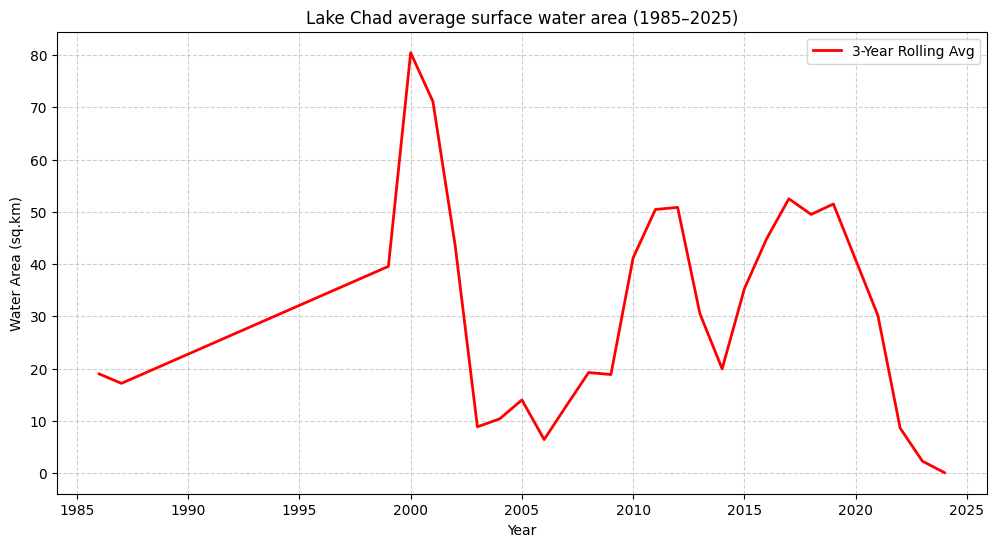

In [41]:
import pandas as pd
df = pd.read_csv(r"C:\Users\ayush\Downloads\lake_area_export_new.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df['year'] = df['date'].dt.year
df_yearly = df.groupby('year')['water_area'].mean().reset_index()
df_yearly = df_yearly[df_yearly["water_area"] > 0]
df_yearly["smoothed"] = df_yearly["water_area"].rolling(window=3, center=True).mean()


plt.figure(figsize=(12,6))
plt.plot(df_yearly["year"], df_yearly["smoothed"], color="red", linewidth=2, label="3-Year Rolling Avg")
plt.legend()
plt.title("Lake Chad average surface water area (1985–2025)")
plt.xlabel("Year")
plt.ylabel("Water Area (sq.km)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

